# Assignment 6: RNN Implementation
-------------------
**Dr. Dave Wanik - University of Connecticut**
A weather-based energy forecasting homework.

* Patricia (PJ) Watson
* 2887247

# Problem Definition

Energy demand forecasting as a function of weather data is an extremely interesting and relevant topic.

I've given you a curated (mostly?) clean dataset that you can use to predict `df['Demand']` as a function of the weather variables.

Of course, you cannot use the df[`Datetime`] column directly into the model - but you can feature engineer the column to make features temporal features for modeling like Julian day of year (0-365), week of year, and number of years since 2012.

**Sorting: (5 pts)**
Sort the data from oldest to newest.

**Cleaning: (10 pts)**
Describe and impute (or drop) the missing values using an appropriate method. At this time, you are welcome to perform feature engineering (optional).

**Process as a 3D tensor: (10 pts)**
Process the data as a 3D tensor with a lookback of your choice (use a value greater than or equal to 12).

**Model Architecure: (10 pts)**
You must use a model with:
* at least two recurrent layers
* at least one convolution layer
* dropout (recurrent or between Dense layers)
* appropriate activation functions

**Experiments: (15 pts each, 30 pts total)**
Freeze the model architecutre and perform a *walk-forward validation* where:
* the first 50k samples predict the remaining ~46k samples
* the first 80k samples predict the remaining ~16k samples

Walk-forward validation is very common to use on the job - it shows how your model (ideally) gets better over time as it gets more data to use. Use subheads

**Evaluation (15 points each, 30 pts total)**
Evaluate your model for each of these experiments - hopefully, your model should improve as you give it more data to use! But that depends on your choice of architecture. You should have:
* quantitative error metrics (mean absolute error and others)
* scatterplots of actual vs. predicted
* time series plots of actual vs. predicted

You should also compare to baseline model like persistence (assume today's energy usage is the same as yesterday's - requires you to shift by 24... ask on discussion board if questions!) or ignore the sequence data and treat this as a 2D problem (a regular supervised learning problem!)

**Conclusions (5 pts total)**
* What did you learn from this assignment? Did your walk-forward validation work as you expected it to?
* What else would you do differently next time?
* At least five great bullets please.

# Set Up Environment

In [1]:
!pip install tensorflow

# import modules
from numpy import array

# from tensorflow.keras.preprocessing.text import one_hot

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten, LSTM
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, GRU, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Read Data

What is this data? The Demand column is energy usage. The weather data is for Bradley Airport in Connecticut (BDL).

Original dataset: https://mesonet.agron.iastate.edu/request/download.phtml

    station: three or four character site identifier

    valid: timestamp of the observation

    tmpf: Air Temperature in Fahrenheit, typically @ 2 meters

    dwpf: Dew Point Temperature in Fahrenheit, typically @ 2 meters

    relh: Relative Humidity in %

    drct: Wind Direction in degrees from *true* north

    sknt: Wind Speed in knots

    p01i: One hour precipitation for the period from the observation time to the time of the previous hourly precipitation reset. This varies slightly by site. Values are in inches. This value may or may not contain frozen precipitation melted by some device on the sensor or estimated by some other means. Unfortunately, we do not know of an authoritative database denoting which station has which sensor.

    alti: Pressure altimeter in inches

    mslp: Sea Level Pressure in millibar

    vsby: Visibility in miles

  Documentation: https://www.weather.gov/media/asos/aum-toc.pdf
  used to help feature engineer (see page 25 re: pressure settings)

    All the currently computed pressure elements will continue to be reported by the ASOS with the same or higher
    level of precision as the human report. The pressure parameters available from ASOS are:
        Sensor Pressure
        Altimeter Setting
        Pressure Remarks
        Sea-Level Pressure
        Density Altitude
        Pressure Altitude
        Pressure Change/Tendency
        Station Pressure
    Because accurate pressure is critical, three separate and
    independent pressure sensors are used at towered airport
    locations. At other locations, two pressure sensors are used.
    The ASOS algorithm compares the pressure sensors’ readings and
    issues a pressure report only when there is acceptable agreement
    between at least two sensors.


In [2]:
# https://drive.google.com/file/d/1jdTV2Fwcnv0Sxl3v2hSkdupJaaLvDOIZ/view?usp=sharing
!gdown 1jdTV2Fwcnv0Sxl3v2hSkdupJaaLvDOIZ

Downloading...
From: https://drive.google.com/uc?id=1jdTV2Fwcnv0Sxl3v2hSkdupJaaLvDOIZ
To: /content/BDL_cleanweather_energy (1).csv
100% 7.38M/7.38M [00:00<00:00, 25.1MB/s]


In [3]:
# read data
df = pd.read_csv('BDL_cleanweather_energy (1).csv')

# EDA
Print the first 10 rows using df.head() and use df.info() to examine the data types and missing values.

💚 96427 rows, 11 cols

 dtypes = floats and object (Datetime)

Weather variables
'BDL_tmpf', 'BDL_dwpf', 'BDL_relh', 'BDL_drct','BDL_sknt', 'BDL_p01i', 'BDL_alti', 'BDL_mslp','BDL_vsby' have the same number of missing values (267).

💚 Decision: drop 267 rows from 96,427 row dataset resulting in (96,160,11)

In [4]:
 # first 25 rows to check Datetime format - 24 hr clock?
 # yes, as expected
df.head(25)

,Datetime,Demand,BDL_tmpf,BDL_dwpf,BDL_relh,BDL_drct,BDL_sknt,BDL_p01i,BDL_alti,BDL_mslp,BDL_vsby
0,2019-01-01 00:00:00,2713.617,37.9,37.9,100.00,360.0,4.0,0.0700,29.88,1009.7,5.0
1,2019-01-01 01:00:00,2578.343,37.9,37.9,100.00,360.0,4.0,0.1100,29.79,1006.3,2.0
2,2019-01-01 02:00:00,2467.969,37.9,37.9,100.00,340.0,7.0,0.0100,29.70,1003.3,2.0
3,2019-01-01 03:00:00,2397.140,37.9,37.9,100.00,310.0,6.0,0.0100,29.63,1002.3,1.5
4,2019-01-01 04:00:00,2381.258,37.9,37.9,100.00,140.0,3.0,0.0001,29.58,1001.2,1.5
5,2019-01-01 05:00:00,2422.784,39.9,39.9,100.00,160.0,11.0,0.0000,29.56,1000.4,5.0
6,2019-01-01 06:00:00,2487.799,44.1,44.1,100.00,160.0,11.0,0.0000,29.54,999.8,10.0
7,2019-01-01 07:00:00,2530.716,46.9,46.0,96.66,170.0,11.0,0.0000,29.54,1000.1,10.0
8,2019-01-01 08:00:00,2620.610,48.9,48.0,96.69,170.0,10.0,0.0000,29.56,1000.9,10.0
9,2019-01-01 09:00:00,2794.228,53.6,48.2,86.17,330.0,12.0,0.0000,29.63,1003.1,10.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96427 entries, 0 to 96426
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Datetime  96427 non-null  object 
 1   Demand    96427 non-null  float64
 2   BDL_tmpf  96160 non-null  float64
 3   BDL_dwpf  96160 non-null  float64
 4   BDL_relh  96160 non-null  float64
 5   BDL_drct  96160 non-null  float64
 6   BDL_sknt  96160 non-null  float64
 7   BDL_p01i  96160 non-null  float64
 8   BDL_alti  96160 non-null  float64
 9   BDL_mslp  96160 non-null  float64
 10  BDL_vsby  96160 non-null  float64
dtypes: float64(10), object(1)
memory usage: 8.1+ MB


In [6]:
# list column names for cut/paste later
df.columns



Index(['Datetime', 'Demand', 'BDL_tmpf', 'BDL_dwpf', 'BDL_relh', 'BDL_drct',
       'BDL_sknt', 'BDL_p01i', 'BDL_alti', 'BDL_mslp', 'BDL_vsby'],
      dtype='object')

In [7]:
df.shape

(96427, 11)

## Visualize Data

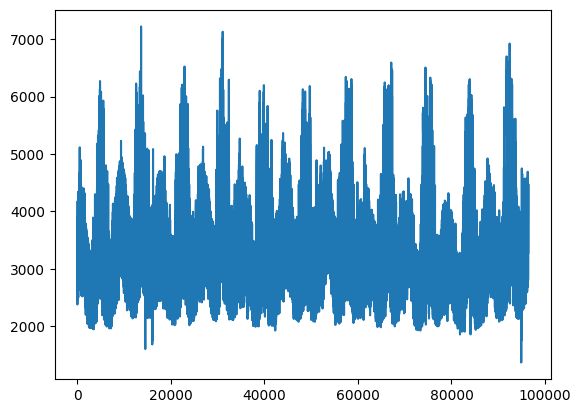

In [8]:
# look at Demand, the target variable in detail
df['Demand'].plot()
plt.show()

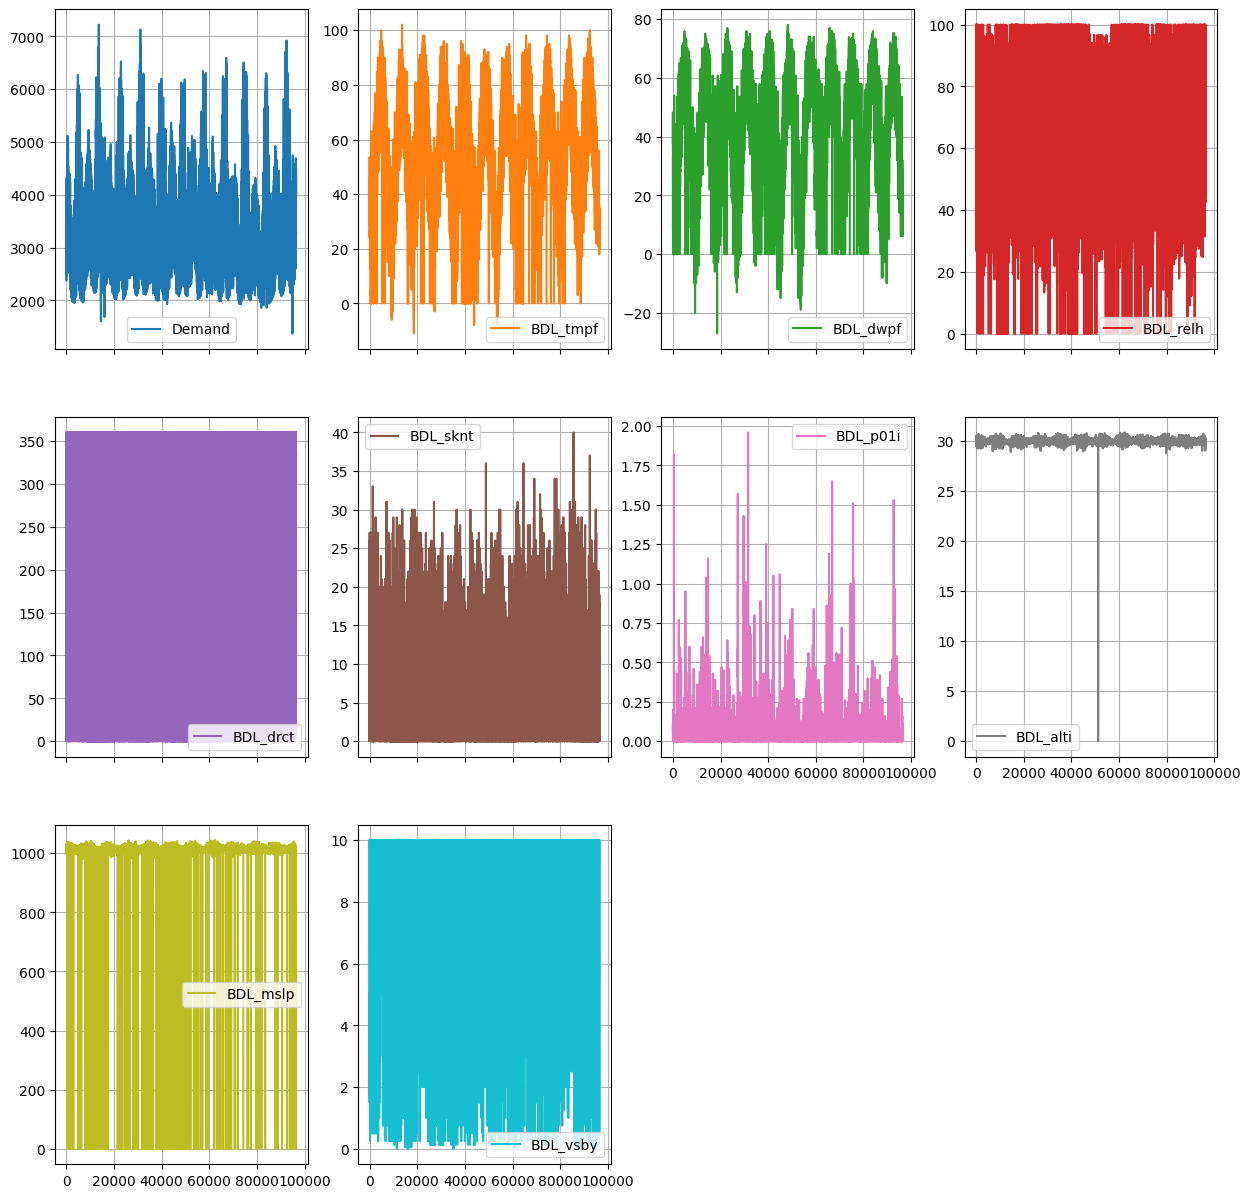

In [9]:
# visualize the rest of the features
df.plot(subplots=True,
        grid=True,
        layout=(3,4),
         figsize=(15,15))
plt.show()

## Examine Select Features

Inspect BDL_drct and BDL_alti to decide whether to keep or drop.

💚 Decision
1. Keep BDL_drct because the range of data is wide
1. Drop BDL_alti to reduce number of features in model, given limited range of data for what is an altimeter setting variable (see documentation)

In [10]:
# inspect BDL_drct, BDL_alti for potential drop based on data viz above
# value counts
df['BDL_drct'].value_counts().sort_values(ascending=False)
# wide range, inspect using summary stats

,count
BDL_drct,
360.0,11721
0.0,9409
180.0,5593
190.0,5031
320.0,4797
330.0,4508
350.0,4383
310.0,4198
200.0,4034


In [11]:
# summary stats for BDL_drct
df['BDL_drct'].describe()

,BDL_drct
count,96160.000000
mean,221.359297
std,118.585969
min,0.000000
25%,170.000000
50%,230.000000
75%,330.000000
max,360.000000


In [12]:
# inspect BDL_drct, BDL_alti for potential drop
# sort the value counts by counts descending

df['BDL_alti'].value_counts().sort_values(ascending=False)


,count
BDL_alti,
29.95,1761
29.98,1752
29.96,1732
30.04,1712
29.93,1701
...,...
29.09,1
28.85,1
28.76,1


In [13]:
# summary stats for BDL_alti
df['BDL_alti'].describe()

,BDL_alti
count,96160.000000
mean,30.018212
std,0.290565
min,0.000000
25%,29.870000
50%,30.020000
75%,30.170000
max,30.850000


In [14]:
# drop 'BDL_alti'
df = df.drop(columns=['BDL_alti'])

In [15]:
# check work
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96427 entries, 0 to 96426
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Datetime  96427 non-null  object 
 1   Demand    96427 non-null  float64
 2   BDL_tmpf  96160 non-null  float64
 3   BDL_dwpf  96160 non-null  float64
 4   BDL_relh  96160 non-null  float64
 5   BDL_drct  96160 non-null  float64
 6   BDL_sknt  96160 non-null  float64
 7   BDL_p01i  96160 non-null  float64
 8   BDL_mslp  96160 non-null  float64
 9   BDL_vsby  96160 non-null  float64
dtypes: float64(9), object(1)
memory usage: 7.4+ MB


## Sort Data: Oldest To Newest

Sorting: (5 pts) Sort the data from oldest to newest.

In [16]:
# sort data oldest to newest
df = df.sort_values(by='Datetime')

# check work
df.head(25)


,Datetime,Demand,BDL_tmpf,BDL_dwpf,BDL_relh,BDL_drct,BDL_sknt,BDL_p01i,BDL_mslp,BDL_vsby
8760,2011-01-01 00:00:00,3053.0,33.98,26.96,0.00,0.0,0.0,0.0,1018.5,6.0
8761,2011-01-01 01:00:00,2892.0,33.98,26.96,0.00,0.0,0.0,0.0,1018.5,6.0
8762,2011-01-01 02:00:00,2774.0,30.92,26.96,0.00,0.0,0.0,0.0,1018.6,6.0
8763,2011-01-01 03:00:00,2710.0,30.02,26.06,0.00,0.0,0.0,0.0,1019.2,5.0
8764,2011-01-01 04:00:00,2698.0,28.94,24.98,0.00,0.0,0.0,0.0,1019.1,5.0
8765,2011-01-01 05:00:00,2737.0,28.94,24.98,0.00,0.0,0.0,0.0,1019.0,5.0
8766,2011-01-01 06:00:00,2829.0,28.94,26.06,0.00,0.0,0.0,0.0,1019.3,5.0
8767,2011-01-01 07:00:00,2892.0,28.94,24.98,0.00,0.0,0.0,0.0,1019.4,4.0
8768,2011-01-01 08:00:00,3052.0,33.98,28.04,78.62,20.0,3.0,0.0,1019.9,4.0
8769,2011-01-01 09:00:00,3192.0,37.94,28.94,0.00,0.0,0.0,0.0,1020.3,5.0


## Clean Data

Cleaning: (10 pts) Describe and impute (or drop) the missing values using an appropriate method. At this time, you are welcome to perform feature engineering (optional).

💚 Some days have a weather observation(s) missing and some days have all weather observations missing for the 24 hour period.

💚 Decision: drop 267 rows from 96,427 row dataset resulting in (96,160,11)

In [17]:
# columns with highest missing values, sorted descending
# (although we can see from df.info the columns with missing values
# have the same number of missing values)

missing_values = df.isnull().sum().sort_values(ascending=False)

# print only where missing values > 0
print(missing_values[missing_values > 0])

BDL_dwpf    267
BDL_tmpf    267
BDL_sknt    267
BDL_p01i    267
BDL_relh    267
BDL_drct    267
BDL_mslp    267
BDL_vsby    267
dtype: int64


In [18]:
# inspect rows with missing values (to see why)
missing_rows = df[df.isnull().any(axis=1)]
pd.set_option("display.max_rows", None)
print(missing_rows)
# with the exccpetion of Demand, some days have missing data, some days are offline entirely

                  Datetime    Demand  BDL_tmpf  BDL_dwpf  BDL_relh  BDL_drct  \
8771   2011-01-01 11:00:00  3325.000       NaN       NaN       NaN       NaN   
9034   2011-01-12 10:00:00  4071.000       NaN       NaN       NaN       NaN   
9169   2011-01-18 01:00:00  3209.000       NaN       NaN       NaN       NaN   
9194   2011-01-19 02:00:00  2882.000       NaN       NaN       NaN       NaN   
9220   2011-01-20 04:00:00  3030.000       NaN       NaN       NaN       NaN   
9338   2011-01-25 02:00:00  3489.000       NaN       NaN       NaN       NaN   
9517   2011-02-01 13:00:00  4693.000       NaN       NaN       NaN       NaN   
9930   2011-02-18 18:00:00  3960.000       NaN       NaN       NaN       NaN   
9985   2011-02-21 01:00:00  2943.000       NaN       NaN       NaN       NaN   
10088  2011-02-25 08:00:00  4047.000       NaN       NaN       NaN       NaN   
10441  2011-03-12 01:00:00  2664.000       NaN       NaN       NaN       NaN   
10442  2011-03-12 02:00:00  2611.000    

In [19]:
# drop 267 rows with missing values
df = df.dropna()

# check work
df.info()

# 96,160 rows, 10 cols

<class 'pandas.core.frame.DataFrame'>
Index: 96160 entries, 8760 to 78859
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Datetime  96160 non-null  object 
 1   Demand    96160 non-null  float64
 2   BDL_tmpf  96160 non-null  float64
 3   BDL_dwpf  96160 non-null  float64
 4   BDL_relh  96160 non-null  float64
 5   BDL_drct  96160 non-null  float64
 6   BDL_sknt  96160 non-null  float64
 7   BDL_p01i  96160 non-null  float64
 8   BDL_mslp  96160 non-null  float64
 9   BDL_vsby  96160 non-null  float64
dtypes: float64(9), object(1)
memory usage: 8.1+ MB


# Prepare Data for Modeling

💚 Approach

1. Feature engineer Datetime to make data temporal. Drop Datetime.

2. Move the temporal variables to the beginning of the dataset.

3.  Move the target variable 'Demand' to the end of the dataset for modeling.

2. The `X` variables will be: 'BDL_tmpf', 'BDL_dwpf', 'BDL_relh', 'BDL_drct','BDL_sknt', 'BDL_p01i', 'BDL_mslp', 'BDL_vsby'

3. The `y` variable will be 'Demand'.

## Datetime Feature Engineering


In [20]:
# to pandas datetime object
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['Julian_Day'] = df['Datetime'].dt.dayofyear
df['Week_of_Year'] = df['Datetime'].dt.isocalendar().week
df['Years_Since_2011'] = df['Datetime'].dt.year - 2011

<ipython-input-20-22b657727df7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Datetime'] = pd.to_datetime(df['Datetime'])
<ipython-input-20-22b657727df7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Julian_Day'] = df['Datetime'].dt.dayofyear
<ipython-input-20-22b657727df7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [21]:
df.info()
# why is week dtype = UInt32??
# The 'Week_of_Year' column is of dtype UInt32 because
# it stores week numbers, which are positive values,
# and a 32-bit unsigned integer is an efficient and
# appropriate data type for this purpose.

<class 'pandas.core.frame.DataFrame'>
Index: 96160 entries, 8760 to 78859
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Datetime          96160 non-null  datetime64[ns]
 1   Demand            96160 non-null  float64       
 2   BDL_tmpf          96160 non-null  float64       
 3   BDL_dwpf          96160 non-null  float64       
 4   BDL_relh          96160 non-null  float64       
 5   BDL_drct          96160 non-null  float64       
 6   BDL_sknt          96160 non-null  float64       
 7   BDL_p01i          96160 non-null  float64       
 8   BDL_mslp          96160 non-null  float64       
 9   BDL_vsby          96160 non-null  float64       
 10  Julian_Day        96160 non-null  int32         
 11  Week_of_Year      96160 non-null  UInt32        
 12  Years_Since_2011  96160 non-null  int32         
dtypes: UInt32(1), datetime64[ns](1), float64(9), int32(2)
memory usage: 9.3 MB


In [22]:
# inspect, check work
df.head(10)

# why is 2011-01-01 considered week 52?
# (trust the algo haha)
# The ISO 8601 standard defines the first week of the year as the week containing the first Thursday of the year.
# This means that:
#   Weeks start on Monday and end on Sunday.
#   The first week of the year is the week that has at least 4 days in the new year.
# In the case of 2011:
#   January 1st, 2011, was a Saturday.
#   The first Thursday of 2011 was January 6th.
#   Therefore, the week containing January 6th (which is the week starting on Monday, January 3rd) is considered week 1 of 2011.

,Datetime,Demand,BDL_tmpf,BDL_dwpf,BDL_relh,BDL_drct,BDL_sknt,BDL_p01i,BDL_mslp,BDL_vsby,Julian_Day,Week_of_Year,Years_Since_2011
8760,2011-01-01 00:00:00,3053.0,33.98,26.96,0.00,0.0,0.0,0.0,1018.5,6.0,1,52,0
8761,2011-01-01 01:00:00,2892.0,33.98,26.96,0.00,0.0,0.0,0.0,1018.5,6.0,1,52,0
8762,2011-01-01 02:00:00,2774.0,30.92,26.96,0.00,0.0,0.0,0.0,1018.6,6.0,1,52,0
8763,2011-01-01 03:00:00,2710.0,30.02,26.06,0.00,0.0,0.0,0.0,1019.2,5.0,1,52,0
8764,2011-01-01 04:00:00,2698.0,28.94,24.98,0.00,0.0,0.0,0.0,1019.1,5.0,1,52,0
8765,2011-01-01 05:00:00,2737.0,28.94,24.98,0.00,0.0,0.0,0.0,1019.0,5.0,1,52,0
8766,2011-01-01 06:00:00,2829.0,28.94,26.06,0.00,0.0,0.0,0.0,1019.3,5.0,1,52,0
8767,2011-01-01 07:00:00,2892.0,28.94,24.98,0.00,0.0,0.0,0.0,1019.4,4.0,1,52,0
8768,2011-01-01 08:00:00,3052.0,33.98,28.04,78.62,20.0,3.0,0.0,1019.9,4.0,1,52,0
8769,2011-01-01 09:00:00,3192.0,37.94,28.94,0.00,0.0,0.0,0.0,1020.3,5.0,1,52,0


## Dataset Housekeeping for Correct Column Order



In [23]:
# drop 'Datetime'
df = df.drop(columns=['Datetime'])

In [24]:
new_order = ['Julian_Day', 'Week_of_Year', 'Years_Since_2011'] + [col for col in df.columns if col not in ['Julian_Day', 'Week_of_Year', 'Years_Since_2011', 'Demand']] + ['Demand']
df = df[new_order]

In [25]:
# inspect, check work, print more than lookback =12 for checking later
df.head(15)

,Julian_Day,Week_of_Year,Years_Since_2011,BDL_tmpf,BDL_dwpf,BDL_relh,BDL_drct,BDL_sknt,BDL_p01i,BDL_mslp,BDL_vsby,Demand
8760,1,52,0,33.98,26.96,0.00,0.0,0.0,0.0,1018.5,6.0,3053.0
8761,1,52,0,33.98,26.96,0.00,0.0,0.0,0.0,1018.5,6.0,2892.0
8762,1,52,0,30.92,26.96,0.00,0.0,0.0,0.0,1018.6,6.0,2774.0
8763,1,52,0,30.02,26.06,0.00,0.0,0.0,0.0,1019.2,5.0,2710.0
8764,1,52,0,28.94,24.98,0.00,0.0,0.0,0.0,1019.1,5.0,2698.0
8765,1,52,0,28.94,24.98,0.00,0.0,0.0,0.0,1019.0,5.0,2737.0
8766,1,52,0,28.94,26.06,0.00,0.0,0.0,0.0,1019.3,5.0,2829.0
8767,1,52,0,28.94,24.98,0.00,0.0,0.0,0.0,1019.4,4.0,2892.0
8768,1,52,0,33.98,28.04,78.62,20.0,3.0,0.0,1019.9,4.0,3052.0
8769,1,52,0,37.94,28.94,0.00,0.0,0.0,0.0,1020.3,5.0,3192.0


In [26]:
# check work at bottom of dataset
df.tail(15)

,Julian_Day,Week_of_Year,Years_Since_2011,BDL_tmpf,BDL_dwpf,BDL_relh,BDL_drct,BDL_sknt,BDL_p01i,BDL_mslp,BDL_vsby,Demand
78845,365,52,10,43.0,42.8,100.00,50.0,5.0,0.0,1015.1,0.25,2945.06
78846,365,52,10,44.6,43.0,95.88,0.0,0.0,0.0,1014.5,3.00,3054.86
78847,365,52,10,46.4,44.6,93.40,50.0,2.0,0.0,1013.8,10.00,3114.86
78848,365,52,10,48.2,43.0,86.21,160.0,5.0,0.0,1013.4,10.00,3159.69
78849,365,52,10,48.0,43.0,82.72,180.0,5.0,0.0,1013.3,10.00,3183.10
78850,365,52,10,48.0,43.0,82.72,160.0,7.0,0.0,1013.1,10.00,3196.55
78851,365,52,10,48.0,43.0,82.72,180.0,7.0,0.0,1013.2,10.00,3267.25
78852,365,52,10,46.9,44.1,89.92,160.0,8.0,0.0,1013.4,10.00,3469.12
78853,365,52,10,46.9,45.0,93.40,180.0,8.0,0.0,1013.5,8.00,3588.99
78854,365,52,10,48.0,45.0,89.29,190.0,8.0,0.0,1014.1,7.00,3478.50


In [27]:
# check shape
df.shape
# 96,160 rows, 11 original cols - Datetime - BDL_alti + (3 temporal vars) = 12 cols FOOTS

(96160, 12)

## Prepare Data for Multivariate Modeling

Process as a 3D tensor: (10 pts) Process the data as a 3D tensor with a lookback of your choice (use a value greater than or equal to 12).

Each observation is 1 hour, thus a lookback of 12 relates to 12 hours (could be 24, 36 but will run longer).

In [28]:
## # prep data for modeling (multivariate)
# link: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

from numpy import array

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in np.arange(len(sequences)): # be careful of this line!
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1] # target var 'Demand' at end of ds
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [29]:
# select n_steps/lookback period
n_steps = 12
raw_seq = np.array(df) # store data as numpy array
X, y = split_sequences(raw_seq, n_steps=12)

In [30]:
# inspect
print(X.shape)
print(y.shape)

# 12 cols - target col 'Demand" = 11 cols
# 12 lookback/n_steps
96160-(12-1)
# orig rows - lookback - 1, bec 1st 11 rows don't have enough preceding data, so excluded

(96149, 12, 11)
(96149,)


96149

In [31]:
print(X[0])
print(y[0])
# scroll back to head, looks good

[[1 52 0 33.98 26.96 0.0 0.0 0.0 0.0 1018.5 6.0]
 [1 52 0 33.98 26.96 0.0 0.0 0.0 0.0 1018.5 6.0]
 [1 52 0 30.92 26.96 0.0 0.0 0.0 0.0 1018.6 6.0]
 [1 52 0 30.02 26.06 0.0 0.0 0.0 0.0 1019.2 5.0]
 [1 52 0 28.94 24.98 0.0 0.0 0.0 0.0 1019.1 5.0]
 [1 52 0 28.94 24.98 0.0 0.0 0.0 0.0 1019.0 5.0]
 [1 52 0 28.94 26.06 0.0 0.0 0.0 0.0 1019.3 5.0]
 [1 52 0 28.94 24.98 0.0 0.0 0.0 0.0 1019.4 4.0]
 [1 52 0 33.98 28.04 78.62 20.0 3.0 0.0 1019.9 4.0]
 [1 52 0 37.94 28.94 0.0 0.0 0.0 0.0 1020.3 5.0]
 [1 52 0 42.08 30.92 0.0 0.0 0.0 0.0 1019.3 5.0]
 [1 52 0 48.02 33.98 0.0 0.0 0.0 0.0 1017.5 6.0]]
3318.0


In [32]:
# split the data into train and test partitions
# use 90% of the data for train
train_pct_index = int(0.9 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]

# no shuffling (we don't want temporal leakage, keeps time series intact)

In [33]:
# check shape
print(X.shape, X_train.shape, X_test.shape)
print(y.shape, y_train.shape, y_test.shape)

# FOOTS

(96149, 12, 11) (86534, 12, 11) (9615, 12, 11)
(96149,) (86534,) (9615,)


# Model Architecture: Model #1 (full dataset): Conv1D, MaxPooling1D(2), (2) SimpleRRs with recurrent_dropout(0.1) and Dropout(0.1)


    You must use a model with:

    at least two recurrent layers

    at least one convolution layer

    dropout (recurrent or between Dense layers)

    appropriate activation functions


💚 Approach: Model #1:

Run Model #1 without freezing/walk-forward experiments at first to see what the MAE is. Repeat for experiments with walk-forward validation using the first 50,000 rows to predict the remaining rows, then using the first 80,000 rows to predict the remaining rows. Compare MAEs.

1. Start with one convolutional layer first
2. Add two recurrent layers

  a. remember to use return_sequences

3. For dropout, use recuurent_dropout in last recurrent layer, and/or (plain vanilla) dropout between dense layers

4. Instructions didn't mention maxpooling, but was added for Model #1

5. Activation function should be for regression (predicting a value for 'Demand', not classification) ('relu')

6. Assess performance (loss='mse',metrics=['mae'])


In [34]:
# refresh X_train and set up vars for model
X_train.shape
n_steps = X_train.shape[1]
n_features = X_train.shape[2]
# samples/lookback/cols
print('This is the shape of X_train:', X_train.shape)
print('This is the lookback:', n_steps)
print('This is the number of features:', n_features)

This is the shape of X_train: (86534, 12, 11)
This is the lookback: 12
This is the number of features: 11


In [35]:
# define model #1 (baseline simple model to start)
model = Sequential()
# convolution does elementwise multiplication and pooling
model.add(Conv1D(filters=16, kernel_size=3, input_shape=(n_steps,n_features)))
model.add(MaxPooling1D(2))
# divide by 2 - remainder, if any, is discarded
model.add(SimpleRNN(32, activation='relu', return_sequences=True))
model.add(SimpleRNN(64, activation='relu',
                    recurrent_dropout=0.1))
model.add(Dropout(0.1)) # generally 0.1 - 0.3
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse',metrics=['mae'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 10, 16)              │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 5, 16)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 5, 32)               │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 64)                  │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,385 (32.75 KB)

 Trainable params: 8,385 (32.75 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
es = EarlyStopping(monitor='val_loss', mode='min',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

# integer error
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)


# fit model (uses early stopping)
model.fit(X_train, y_train,     # ran 25 min
          epochs=500,
          batch_size=5,
          validation_split=0.2, # val is a random 20% of the data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)
# ran 25 min
# Epoch 27: early stopping
# Restoring model weights from the end of the best epoch: 17 MAE = 247.890

Epoch 1/500
13846/13846 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step - loss: 519515.3750 - mae: 546.8623 - val_loss: 214194.7969 - val_mae: 370.6609
Epoch 2/500
13846/13846 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - loss: 222301.2812 - mae: 375.3735 - val_loss: 134414.6250 - val_mae: 288.1964
Epoch 3/500
13846/13846 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - loss: 205784.7656 - mae: 360.4540 - val_loss: 168585.7031 - val_mae: 325.8123
Epoch 4/500
13846/13846 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - loss: 191735.8594 - mae: 346.1648 - val_loss: 143432.2500 - val_mae: 296.1549
Epoch 5/500
13846/13846 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - loss: 186946.3438 - mae: 341.6194 - val_loss: 118868.4297 - val_mae: 268.4680
Epoch 6/500
13846/13846 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - loss: 182878.5781 - mae: 336.4213 - val_loss: 122658.3594 - val_mae: 272.1366
Epoch 7/500
13846/13846 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - loss: 178119.4375 - mae: 332.8146 - val_loss: 128320.6719 - val_mae: 280.9237
Epoch 8/500
13846/13846 ━━━━━━━━━━

### Evaluation: MAE = 240.14634580266025

301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
MAE:  240.14634580266025


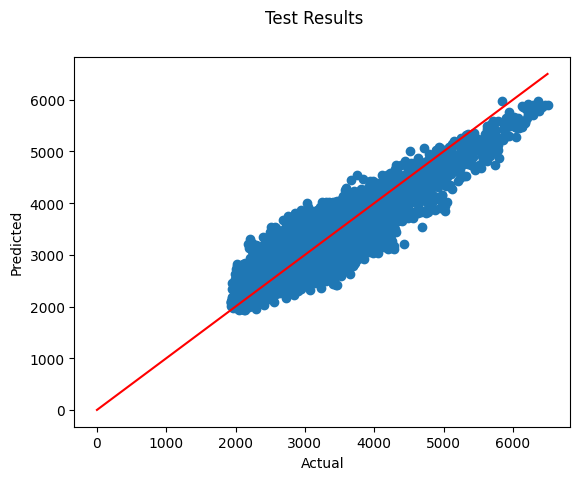

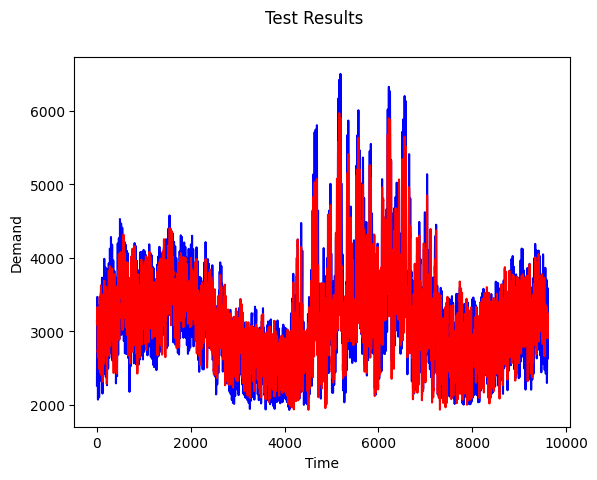

In [37]:
# show scatterplots of actual vs. predicted
# make a prediction
X_test = X_test.astype(np.float32)
pred = model.predict(X_test)# the pred

# calculate MSE for the baseline model
print('MAE: ', mean_absolute_error(y_test, pred))

actual = y_test # the actual
plt.scatter(x=actual, y=pred)
x = np.linspace(0,6500) # 45 degree line from 0 to 6500
plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
# looks pretty good!

# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.show()

# Experiments

Freeze the model architecutre and perform a walk-forward validation where:

the first 50k samples predict the remaining ~46k samples

the first 80k samples predict the remaining ~16k samples

💚 Results

1. Walk-forward validation with first 50,000 samples:

  MAE = 293.5306758191283

2. Walk-forward validation with first 80,000 samples:

  MAE = 247.86593268038078



## Walk-Forward Validation: First 50k Samples

Perform walk-forward validation where the first 50k samples predict the remaining ~46k samples.

💚 Approach
1. Train model using first 50,000 samples
2. Apply to remaining 46,149 samples to generate Demand predictions
3. Evaluate using MAE

In [38]:
# refresh what was done originally for full dataset with 90/10 split
# split the data into train and test partitions
# use 90% of the data for train
# train_pct_index = int(0.9 * len(X))
# X_train, X_test = X[:train_pct_index], X[train_pct_index:]
# y_train, y_test = y[:train_pct_index], y[train_pct_index:]

In [39]:
# split data into initial training samples (50,000) and walk-forward validation samples (46,149)
X_train_first_fiftythousand = X[:50000]
y_train_first_fiftythousand = y[:50000]
X_walk_forward = X[50000:]
y_walk_forward = y[50000:]

In [40]:
# check work
print('X_train_first_fiftythousand:', X_train_first_fiftythousand.shape)
print('y_train_first_fiftythousand:', y_train_first_fiftythousand.shape)
print('X_walk_forward:', X_walk_forward.shape)
print('y_walk_forward:', y_walk_forward.shape)


X_train_first_fiftythousand: (50000, 12, 11)
y_train_first_fiftythousand: (50000,)
X_walk_forward: (46149, 12, 11)
y_walk_forward: (46149,)


In [41]:
# define same Model #1 but with X_train_first_fiftythousand
model = Sequential()
model.add(Conv1D(filters=16, kernel_size=3, input_shape=(X_train_first_fiftythousand.shape[1], X_train_first_fiftythousand.shape[2])))
model.add(MaxPooling1D(2))
model.add(SimpleRNN(32, activation='relu', return_sequences=True))
model.add(SimpleRNN(64, activation='relu', recurrent_dropout=0.1))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [42]:
es = EarlyStopping(monitor='val_loss', mode='min',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

# integer error
X_train_first_fiftythousand = X_train_first_fiftythousand.astype(np.float32)
y_train_first_fiftythousand = y_train_first_fiftythousand.astype(np.float32)


# fit model (uses early stopping)
model.fit(X_train_first_fiftythousand, y_train_first_fiftythousand,
          epochs=50,    # reduced from 500 to 50
          batch_size=5,
          validation_split=0.2, # val is a random 20% of the data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)

# Epoch 28: early stopping
# Restoring model weights from the end of the best epoch: 18,  MAE = 268.6624

Epoch 1/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 727480.2500 - mae: 639.8201 - val_loss: 232666.3438 - val_mae: 386.4553
Epoch 2/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 275223.4062 - mae: 420.0732 - val_loss: 286260.1875 - val_mae: 428.4995
Epoch 3/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 254069.2344 - mae: 402.0532 - val_loss: 178021.3281 - val_mae: 327.5716
Epoch 4/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 237497.0156 - mae: 388.0445 - val_loss: 180207.8750 - val_mae: 338.3253
Epoch 5/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 227167.2500 - mae: 379.2320 - val_loss: 165169.5312 - val_mae: 315.9735
Epoch 6/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 223461.7031 - mae: 376.3654 - val_loss: 144968.3750 - val_mae: 293.9763
Epoch 7/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 212666.0625 - mae: 367.0557 - val_loss: 251604.4531 - val_mae: 391.8089
Epoch 8/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step 

1443/1443 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
MAE:  282.51603107868


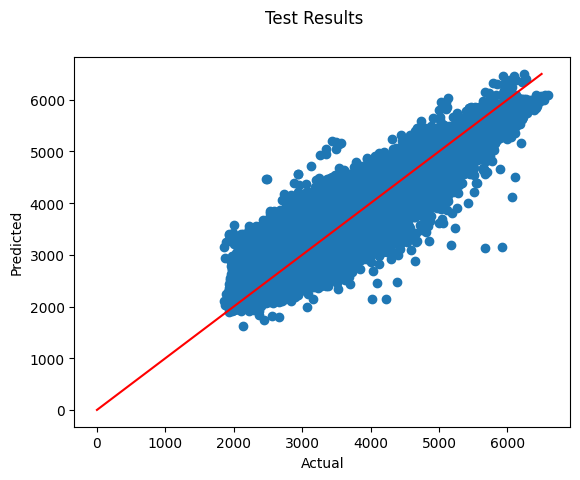

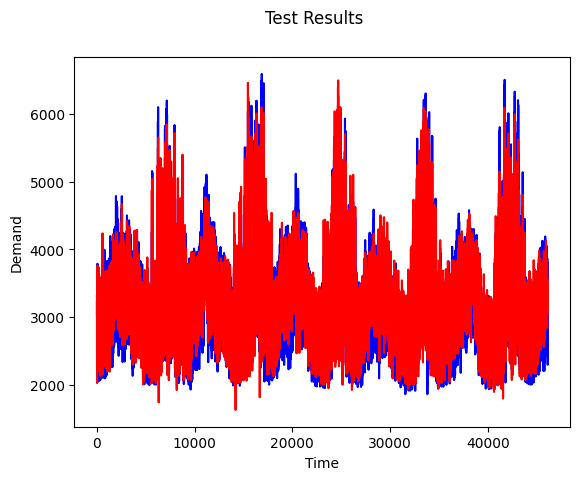

In [43]:
# show scatterplots of actual vs. predicted
# make a prediction

# we are working with
# X_walk_forward: (46149, 12, 11)
# y_walk_forward: (46149,)

# X_test = X_test.astype(np.float32)
X_walk_forward = X_walk_forward.astype(np.float32)

# pred = model.predict(X_test)    # predictions
pred = model.predict(X_walk_forward)    # predictions

# calculate MSE for the baseline model
# from sklearn.metrics import mean_absolute_error
# print('MAE: ', mean_absolute_error(y_test, pred))
print('MAE: ', mean_absolute_error(y_walk_forward, pred))

# actual = y_test       # the actual
actual = y_walk_forward # the actual
plt.scatter(x=actual, y=pred)
x = np.linspace(0,6500) # 45 degree line from 0 to 6500
plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
# looks ok

# show timeseries plot
# plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_walk_forward.shape[0]), y_walk_forward, color='blue') # actual data
# plt.plot(np.arange(X_test.shape[0]), pred, color='red') # predicted data
plt.plot(np.arange(X_walk_forward.shape[0]), pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.show()

### Evaluation: MAE = 282.51603107868

## Walk-Forward Validation: First 80k Samples

Perform walk-forward validation where the first 80k samples predict the remaining ~16k samples.

💚 Approach
1. Train model using first 80,000 samples
2. Apply to remaining 16,149 samples to generate Demand predictions
3. Evaluate using MAE

In [44]:
# split data into initial training and walk-forward validation sets
X_train_first_eightythousand = X[:80000]
y_train_first_eightythousand = y[:80000]
X_walk_forward = X[80000:]
y_walk_forward = y[80000:]

In [45]:
# check work
print('X_train_first_eightythousand:', X_train_first_eightythousand.shape)
print('y_train_first_eightythousand:', y_train_first_eightythousand.shape)
print('X_walk_forward:', X_walk_forward.shape)
print('y_walk_forward:', y_walk_forward.shape)

X_train_first_eightythousand: (80000, 12, 11)
y_train_first_eightythousand: (80000,)
X_walk_forward: (16149, 12, 11)
y_walk_forward: (16149,)


In [46]:
# define same Model #1 but with X_train_first_eightythousand
model = Sequential()
model.add(Conv1D(filters=16, kernel_size=3, input_shape=(X_train_first_eightythousand.shape[1], X_train_first_eightythousand.shape[2])))
model.add(MaxPooling1D(2))
model.add(SimpleRNN(32, activation='relu', return_sequences=True))
model.add(SimpleRNN(64, activation='relu', recurrent_dropout=0.1))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [47]:
es = EarlyStopping(monitor='val_loss', mode='min',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

# integer error
X_train_first_eightythousand = X_train_first_eightythousand.astype(np.float32)
y_train_first_eightythousand = y_train_first_eightythousand.astype(np.float32)


# fit model (uses early stopping)
model.fit(X_train_first_eightythousand, y_train_first_eightythousand,
          epochs=50,
          batch_size=5,
          validation_split=0.2, # val is a random 20% of the data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)
# Epoch 31: early stopping
# Restoring model weights from the end of the best epoch: 21, MAE = 255.9287

Epoch 1/50
12800/12800 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - loss: 562046.9375 - mae: 570.5910 - val_loss: 139201.4844 - val_mae: 304.4987
Epoch 2/50
12800/12800 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 248422.8281 - mae: 397.3640 - val_loss: 155277.3438 - val_mae: 316.3863
Epoch 3/50
12800/12800 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 216426.9688 - mae: 369.4315 - val_loss: 148129.5156 - val_mae: 304.8037
Epoch 4/50
12800/12800 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 204711.9844 - mae: 358.5986 - val_loss: 127897.1250 - val_mae: 283.6461
Epoch 5/50
12800/12800 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 197773.4844 - mae: 352.3759 - val_loss: 121551.8984 - val_mae: 275.2538
Epoch 6/50
12800/12800 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 193114.5469 - mae: 347.6695 - val_loss: 132084.9375 - val_mae: 286.4080
Epoch 7/50
12800/12800 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 189015.3281 - mae: 343.6647 - val_loss: 113225.3203 - val_mae: 266.2050
Epoch 8/50
12800/12800 ━━━━━━━━━━━━━━━━━━

### Evaluation: MAE = 250.95412281696042


505/505 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
MAE:  250.95412281696042


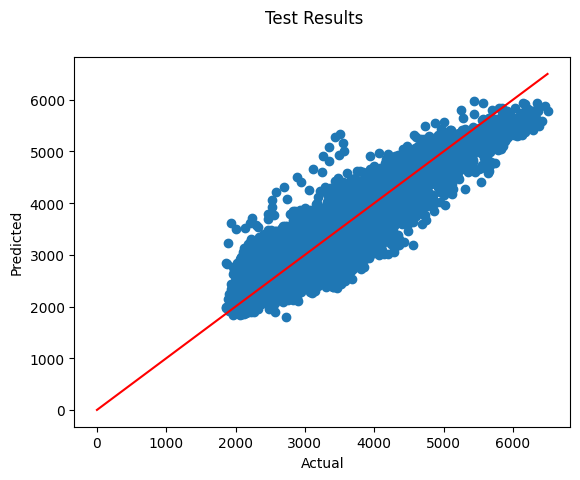

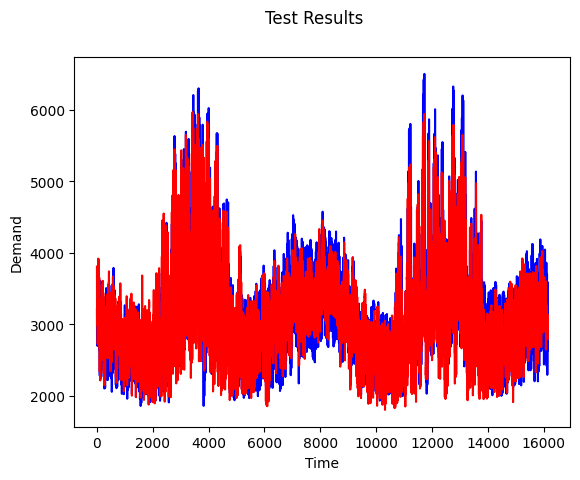

In [48]:
# show scatterplots of actual vs. predicted
# make a prediction

# we are working with
# X_walk_forward: (16149, 12, 11)
# y_walk_forward: (16149,)

# X_test = X_test.astype(np.float32)
X_walk_forward = X_walk_forward.astype(np.float32)

# pred = model.predict(X_test)    # predictions
pred = model.predict(X_walk_forward)    # predictions

# calculate MSE for the baseline model
# from sklearn.metrics import mean_absolute_error
# print('MAE: ', mean_absolute_error(y_test, pred))
print('MAE: ', mean_absolute_error(y_walk_forward, pred))

# actual = y_test       # the actual
actual = y_walk_forward # the actual
plt.scatter(x=actual, y=pred)
x = np.linspace(0,6500) # 45 degree line from 0 to 6500
plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
# looks ok

# show timeseries plot
# plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_walk_forward.shape[0]), y_walk_forward, color='blue') # actual data
# plt.plot(np.arange(X_test.shape[0]), pred, color='red') # predicted data
plt.plot(np.arange(X_walk_forward.shape[0]), pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.show()

# Baseline Comparison: Persistence

Compare to baseline model like persistence (assume today's energy usage is the same as yesterday's, shifting by 24 or ignore the sequence data and treat this as a 2D problem (a regular supervised learning problem).

Reference: Univariate Temperature_RNN_Advanced.ipynb

💚 Result: MAE = 238.3327237649506

## Prepare Data for Modeling

Shift data 24 hours, inspect.


In [49]:
# baseline model - prediction is the previous day's Demand (24 hours)
df['Baseline'] = df['Demand'].shift(24)
df.head(30)
# scroll right, inspect Demand

,Julian_Day,Week_of_Year,Years_Since_2011,BDL_tmpf,BDL_dwpf,BDL_relh,BDL_drct,BDL_sknt,BDL_p01i,BDL_mslp,BDL_vsby,Demand,Baseline
8760,1,52,0,33.98,26.96,0.00,0.0,0.0,0.00,1018.5,6.00,3053.0,NaN
8761,1,52,0,33.98,26.96,0.00,0.0,0.0,0.00,1018.5,6.00,2892.0,NaN
8762,1,52,0,30.92,26.96,0.00,0.0,0.0,0.00,1018.6,6.00,2774.0,NaN
8763,1,52,0,30.02,26.06,0.00,0.0,0.0,0.00,1019.2,5.00,2710.0,NaN
8764,1,52,0,28.94,24.98,0.00,0.0,0.0,0.00,1019.1,5.00,2698.0,NaN
8765,1,52,0,28.94,24.98,0.00,0.0,0.0,0.00,1019.0,5.00,2737.0,NaN
8766,1,52,0,28.94,26.06,0.00,0.0,0.0,0.00,1019.3,5.00,2829.0,NaN
8767,1,52,0,28.94,24.98,0.00,0.0,0.0,0.00,1019.4,4.00,2892.0,NaN
8768,1,52,0,33.98,28.04,78.62,20.0,3.0,0.00,1019.9,4.00,3052.0,NaN
8769,1,52,0,37.94,28.94,0.00,0.0,0.0,0.00,1020.3,5.00,3192.0,NaN


In [50]:
# use df['Baseline'] for predictions
# df['Baseline'] contains the shifted Demand values (yesterday's energy usage).

y_test_baseline = df['Baseline'].tail(y_test.shape[0])    # y_test original dataset

# .tail() selects rows from the end of the df
# y_test.shape[0] tells us # rows in y_test, extracts last n rows from 'Baseline' col,
# where n = size of the test set, so baseline predictions = test set observations

y_test_baseline = df['Baseline'].tail(y_test.shape[0])
# check work
y_test_baseline.shape

(9615,)

In [51]:
# check work

print(X.shape, X_train.shape, X_test.shape)
print(y.shape, y_train.shape, y_test.shape)

# FOOTS

(96149, 12, 11) (86534, 12, 11) (9615, 12, 11)
(96149,) (86534,) (9615,)


## Evaluation: MAE = 238.3327237649506

MAE:  238.3327237649506


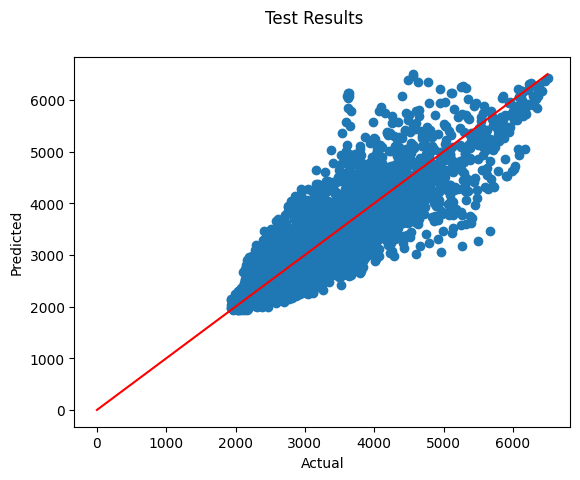

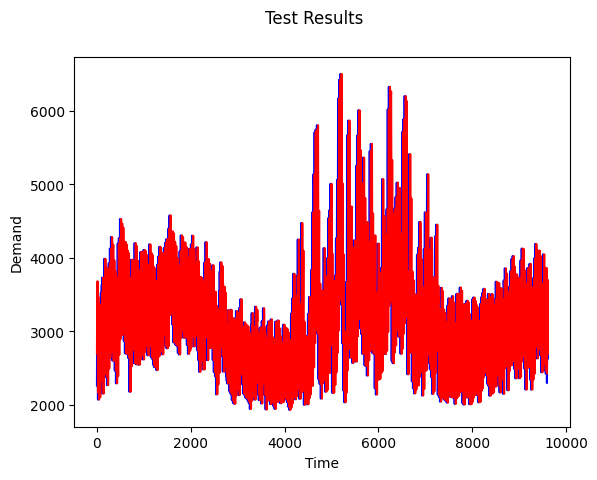

In [52]:
# show scatterplots of actual vs. predicted
# make a prediction
pred = y_test_baseline  # the pred

# calculate MSE for the baseline model
print('MAE: ', mean_absolute_error(y_test, pred))

actual = y_test         # the actual
plt.scatter(x=actual, y=pred)
x = np.linspace(0,6500) # 45 degree line from 0 to 6500
plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
# NOTE better symmetry around 45 degree line


# show timeseries plot
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.show()
# looks good, BUT it's not a smart model! all the data is just shifted (DD comment)

# Model Architecture: Model #2 (full dataset): Conv1D, MaxPooling1D(2), (2) LSTMs with recurrent_dropout(0.1) and Dropout(0.1)

Refresh Model Performance:

Model #1: full dataset **MAE 251.80**
  Conv1D, MaxPooling1D(2), (2) SimmpleRNNs with recurrent_dropout = 0.1, Dropout = 0.1

Walk-Forward 50% Samples: **MAE 310.13**

Walk-Forward 80% Samples: **MAE 250.48**

Baseline Comparison Model: 24 Hour Shift **MAE 238.33**

**Can we beat the Baseline Comparison model (MAE = 238.33) by modifying Model #1, replacing SimpleRNNs with LSTMs? **

💚 Result: MAE = 273.3904398213038


In [53]:
# refresh X_train and set up vars for model
X_train.shape
n_steps = X_train.shape[1]
n_features = X_train.shape[2]
# samples/lookback/cols
print('This is the shape of X_train:', X_train.shape)
print('This is the lookback:', n_steps)
print('This is the number of features:', n_features)

This is the shape of X_train: (86534, 12, 11)
This is the lookback: 12
This is the number of features: 11


In [54]:
# define Model #2 (Model #1 with SimpleRNNs replaced with LSTMs)
# all else remains constant
model = Sequential()
# convolution does elementwise multiplication and pooling
model.add(Conv1D(filters=16, kernel_size=3, input_shape=(n_steps,n_features)))
model.add(MaxPooling1D(2))
# divide by 2 - remainder, if any, is discarded
# model.add(SimpleRNN(32, activation='relu', return_sequences=True))
# model.add(SimpleRNN(64, activation='relu',
#                    recurrent_dropout=0.1))
model.add(LSTM(32, activation='relu', recurrent_dropout=0.1, return_sequences=True))
model.add(LSTM(64, activation='relu', recurrent_dropout=0.1))   # note no return_seq
model.add(Dropout(0.1)) # generally 0.1 - 0.3
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse',metrics=['mae'])
model.summary()

# check out the impact on trainable parms (31,713) compared to Model #1 (8,385)
# due to gates/cell states

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 10, 16)              │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 5, 16)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 5, 32)               │           6,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,713 (123.88 KB)

 Trainable params: 31,713 (123.88 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
es = EarlyStopping(monitor='val_loss', mode='min',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

# integer error
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)


# fit model (uses early stopping)
model.fit(X_train, y_train,
          epochs=50,
          batch_size=5,
          validation_split=0.2, # val is a random 20% of the data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)
# ran 25 min
# Epoch 21: early stopping
# Restoring model weights from the end of the best epoch: 11, MAE = 293.0906

Epoch 1/50
13846/13846 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - loss: 928425.2500 - mae: 733.7379 - val_loss: 308506.3438 - val_mae: 438.4671
Epoch 2/50
13846/13846 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - loss: 422013.6250 - mae: 514.2922 - val_loss: 174492.7656 - val_mae: 338.8997
Epoch 3/50
13846/13846 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step - loss: 319973.4375 - mae: 451.0588 - val_loss: 239196.6406 - val_mae: 392.2893
Epoch 4/50
13846/13846 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - loss: 301517.3750 - mae: 439.7892 - val_loss: 264024.5312 - val_mae: 416.9012
Epoch 5/50
13846/13846 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - loss: 294864.7812 - mae: 435.2165 - val_loss: 177473.9688 - val_mae: 339.5598
Epoch 6/50
13846/13846 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - loss: 275499.2500 - mae: 421.9948 - val_loss: 138029.8594 - val_mae: 297.4928
Epoch 7/50
13846/13846 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - loss: 272544.1875 - mae: 415.5479 - val_loss: 149515.5156 - val_mae: 310.0275
Epoch 8/50
13846/13846 ━━━━━━━━━━━━━━━━━━

301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
MAE:  292.2385478126625


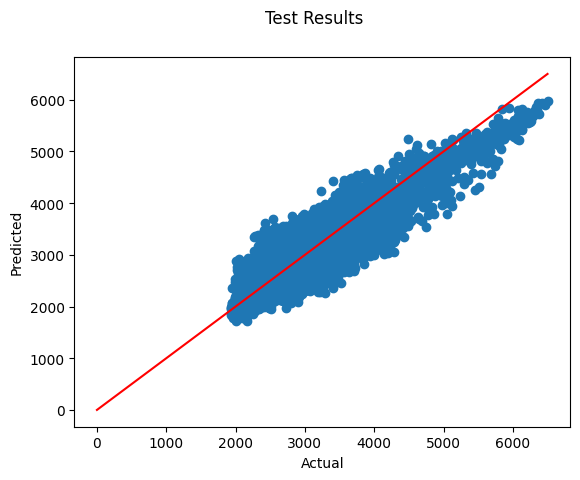

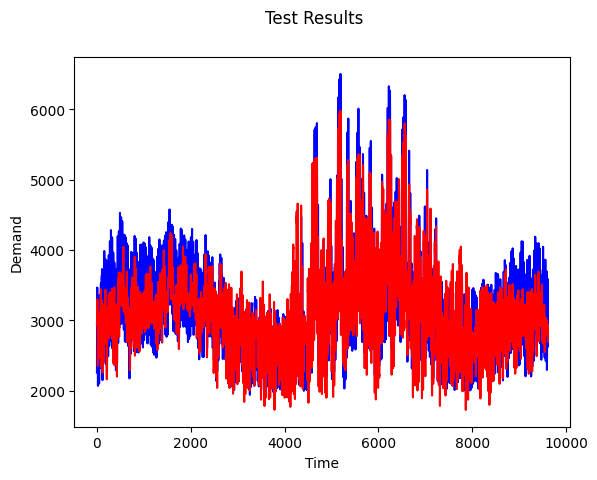

In [56]:
# show scatterplots of actual vs. predicted
# make a prediction
X_test = X_test.astype(np.float32)
pred = model.predict(X_test)# the pred

# calculate MSE for the baseline model
print('MAE: ', mean_absolute_error(y_test, pred))

actual = y_test # the actual
plt.scatter(x=actual, y=pred)
x = np.linspace(0,6500) # 45 degree line from 0 to 6500
plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
# looks pretty good!

# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.show()

## Evaluation: MAE = 292.2385478126625

# Model Architecture: Model #3 (full dataset): (2) Conv1D, (2) MaxPooling1D(2), (2) LSTMs with recurrent_dropout(0.1) and Dropout(0.1)

In [57]:
# define model
model = Sequential()
# convolution does elementwise multiplication and pooling
model.add(Conv1D(filters=16, kernel_size=3, input_shape=(n_steps,n_features))) # notice how input shape goes in first layer
model.add(MaxPooling1D(2))
model.add(Conv1D(filters=16, kernel_size=3))
model.add(MaxPooling1D(2))    # divide by 2 and change is discarded
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(LSTM(64, activation='relu',
                    recurrent_dropout=0.1))
model.add(Dropout(0.1)) # 0.1 - 0.3
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse',metrics=['mae'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                    │ (None, 10, 16)              │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 5, 16)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 3, 16)               │             784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 1, 16)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 1, 32)               │           6,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,497 (126.94 KB)

 Trainable params: 32,497 (126.94 KB)

 Non-trainable params: 0 (0.00 B)

In [58]:
es = EarlyStopping(monitor='val_loss', mode='min',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

# integer error
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)


# fit model (uses early stopping)
model.fit(X_train, y_train,
          epochs=50,
          batch_size=5,
          validation_split=0.2, # val is a random 20% of the data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)
# ran XX min
# Epoch 21: early stopping
# Restoring model weights from the end of the best epoch: 11, MAE = 285.9087

Epoch 1/50
13846/13846 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - loss: 806484.2500 - mae: 657.2947 - val_loss: 181245.4375 - val_mae: 341.4807
Epoch 2/50
13846/13846 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 311032.7500 - mae: 446.7248 - val_loss: 365584.0000 - val_mae: 483.0089
Epoch 3/50
13846/13846 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 268779.4375 - mae: 413.5681 - val_loss: 245568.8125 - val_mae: 392.9765
Epoch 4/50
13846/13846 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - loss: 257255.1875 - mae: 403.3333 - val_loss: 145521.1875 - val_mae: 304.0324
Epoch 5/50
13846/13846 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 247340.2812 - mae: 394.7894 - val_loss: 138238.8906 - val_mae: 296.7226
Epoch 6/50
13846/13846 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 242756.6406 - mae: 391.5404 - val_loss: 145307.0000 - val_mae: 302.5922
Epoch 7/50
13846/13846 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 235293.4062 - mae: 386.4376 - val_loss: 148410.2500 - val_mae: 302.9323
Epoch 8/50
13846/13846 ━━━━━━━━━━━━━━━━━━

301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
MAE:  296.51957865009916


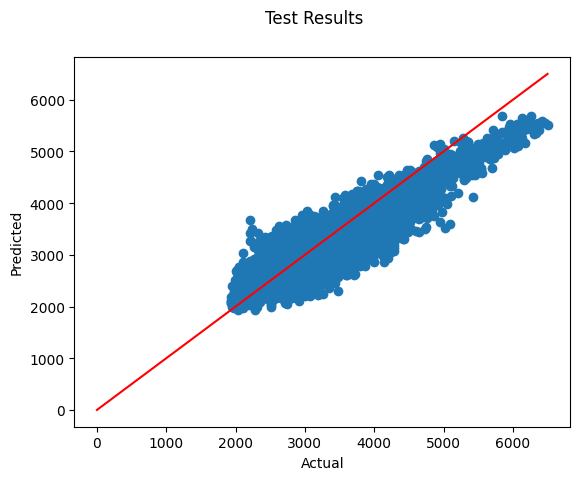

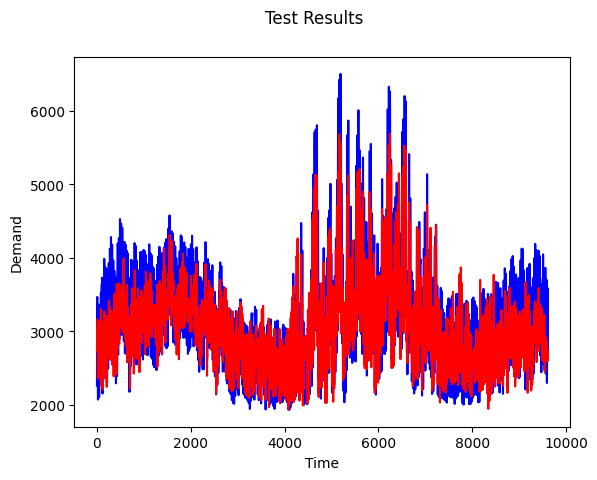

In [59]:
# show scatterplots of actual vs. predicted
# make a prediction
X_test = X_test.astype(np.float32)
pred = model.predict(X_test)# the pred

# calculate MSE for the baseline model
print('MAE: ', mean_absolute_error(y_test, pred))

actual = y_test # the actual
plt.scatter(x=actual, y=pred)
x = np.linspace(0,6500) # 45 degree line from 0 to 6500
plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
# looks pretty good!

# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.show()

## Evaluation: MAE = 296.51957865009916

# Model Tracker
# **Final Run All**

  Model #1: full dataset **MAE 240.15**
      Conv1D, MaxPooling1D(2), (2) SimpleRNNs with recurrent_dropout = 0.1, Dropout = 0.1

  Walk-Forward 50% Samples: **MAE 282.52**

  Walk-Forward 80% Samples: **MAE 250.95**

  Baseline Comparison Model: 24 Hour Shift **MAE 238.33**

  Model #2: full dataset **MAE 292.24**
      Conv1D, MaxPooling1D(2), (2) LSTMs with recurrent_dropout = 0.1, Dropout = 0.1

  Model #3: full dataset **MAE 296.52**
      (2)Conv1D, (2) MaxPooling1D(2), (2) LSTMs with recurrent_dropout = 0.1, Dropout = 0.1



# **Initial Run All** (emailed to DrD)

  Model #1 full dataset baseline **MAE = 255.75**
      Conv1D, MaxPooling1D(2), (2) SimpleRRs with
      recurrent_dropout(0.1) and Dropout(0.1)


  Walk-Forward 50% Samples **MAE = 293.53**

  Walk-Forward 80% Samples **MAE = 247.87**

  OK, better than 50k samples, but want to discuss relative to Model #1 MAE

  Baseline Comparison Model: 24 Hour Shift  **MAE = 238.33**

  Tried/played around with these models to compare to Model #1:

  Model #2 full dataset  **MAE = 273.39**
      Conv1D, MaxPooling1D(2), (2) LSTMs with
      recurrent_dropout(0.1) and Dropout(0.1)

  Model #3 full dataset **MAE = 256.10**
      (2) Conv1D, (2) MaxPooling1D(2), (2)LSTM with recurrent_dropout(0.1) and Dropout(0.1)




# Conclusions

What did you learn from this assignment? Did your walk-forward validation work as you expected it to?
What else would you do differently next time?
At least five great bullets please.

Bullets:

1. It may be obvious, but I feel that reading about the data in detail is a step that can be slighted or overlooked. I found it helpful to familiarize myself with the data's documentation (https://www.weather.gov/media/asos/aum-toc.pdf) after visualizing the data to decide what/how to feature engineer
(page 25 re: pressure settings). I tend to want to keep all columns available in a dataset unless I know there's such a positive coorelation between features that one can be dropped without losing intell. After visualizing the data, I initially thought BDL_drct (Wind Direction in degrees from *true* north) and BDL_alti (Pressure altimeter in inches) were candidates for dropping. After looking at the distribution of the data (much smaller for BDL_alti) and reading the documentation about pressure sensors, I decided BDL_alti could be dropped (and kept BDL_drct).

2. I learned that the only constant MAE is the baseline persistence MAE - not unexpectedly, but it was interesting to see the dispersion of MAEs from my initial run (emailed to DrD) and my final run. Comparing MAEs (see Model Tracker), my final run's Model #1 did better than my initial run's Model #1 (240 vs 256), but Models #2 and #3 did worse (292, 297 vs 273, 256 respectively). I understand the assignment was really about the 50%/80% walk forward validation, and the impact on modeling in the real world. I just wanted to try a few different models to see how close to the baseline I could get.

3. The walk forward validation did work as expected, with MAEs of 283, 251, and 240 for the 50% sample, 80% sample and full dataset, respectively, all using the same SimpleRNN model. The model performed better using more data.

4. Looking at the scatterplots, we can see that Model #1 with the full dataset has the tightest dispersion around the 45 degree line compared to the 50% and 80% samples. This is true however only up to a point, after which the Demand predictions are lower than they should be (underestimated). The scatterplots for the 50% and 80% samples show prediction outliers, which look more pronounced in the 80% because they're more distinct as the other predictions get tighter to the 45 degree line. The scatterplots for Models #2 and #3 are similar to Model #1, and what I think I'm seeing is that Demand predictions over a certain level become less accurate. This is not good; you would want a model that can accurately predict high Demand in the real world to be able to accomodate that Demand. The time series plots show this as well - the red predictions don't reach the blue actual peaks. From a business perspective I think you could also calculate the financial impact of the scenarios to understand your exposure - over-estimating low Demand, under-estimating high Demand, etc.
5. The "simpler" Model #1 performed closder to the baseline persistence model than the more complex/more layers LSTMs (Model #2 and Model #3). I'd want to play with filters, kernel size, hidden layers and dropout to compare results between the SimpleRNNs and the LSTMs and try to figure out whether a simpler LSTM would perform better. There was such an impact on the number of trainable parameters going from my Model #1 SimpleRNN (8,385) to the LSTMs (31,713 and 32,497), that I feel it isn't a valid comparison. I'd want to rerun models that have more trainable parameters within the wide range I had between Model #1 and Models #2 and #3.